In [ ]:
import os
import random
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import schedulefree
from safetensors.torch import save_model, load_model

import timm
from tqdm import tqdm, trange

import torchvision
from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import intel_extension_for_pytorch as ipex
print(torch.__version__)
print(ipex.__version__)
[print(f'[{i}]: {torch.xpu.get_device_properties(i)}') for i in range(torch.xpu.device_count())];

device = torch.device("xpu")

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


2.1.0.post2+cxx11.abi
2.1.30.post0 
[0]: _DeviceProperties(name='Intel(R) Arc(TM) A770 Graphics', platform_name='Intel(R) Level-Zero', dev_type='gpu', driver_version='1.3.29803', has_fp64=0, total_memory=15930MB, max_compute_units=512, gpu_eu_count=512)


In [ ]:
# timm.list_models(pretrained=True, filter="convnext*")

## Data

In [ ]:
train_labels = pd.read_csv("train_labels.csv")
cls_labels = train_labels.label.unique()
cls_labels.sort()
NUM_FINETUNE_CLASSES = len(cls_labels)
NUM_FINETUNE_CLASSES, cls_labels

(151,
 array(['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok',
        'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise',
        'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard',
        'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster',
        'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo',
        'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee',
        'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor',
        'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude',
        'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler',
        'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan',
        'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon',
        'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan',
        'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp',
        'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite

In [ ]:
label_map = {label:num for num, label in enumerate(cls_labels)}

<Axes: ylabel='label'>

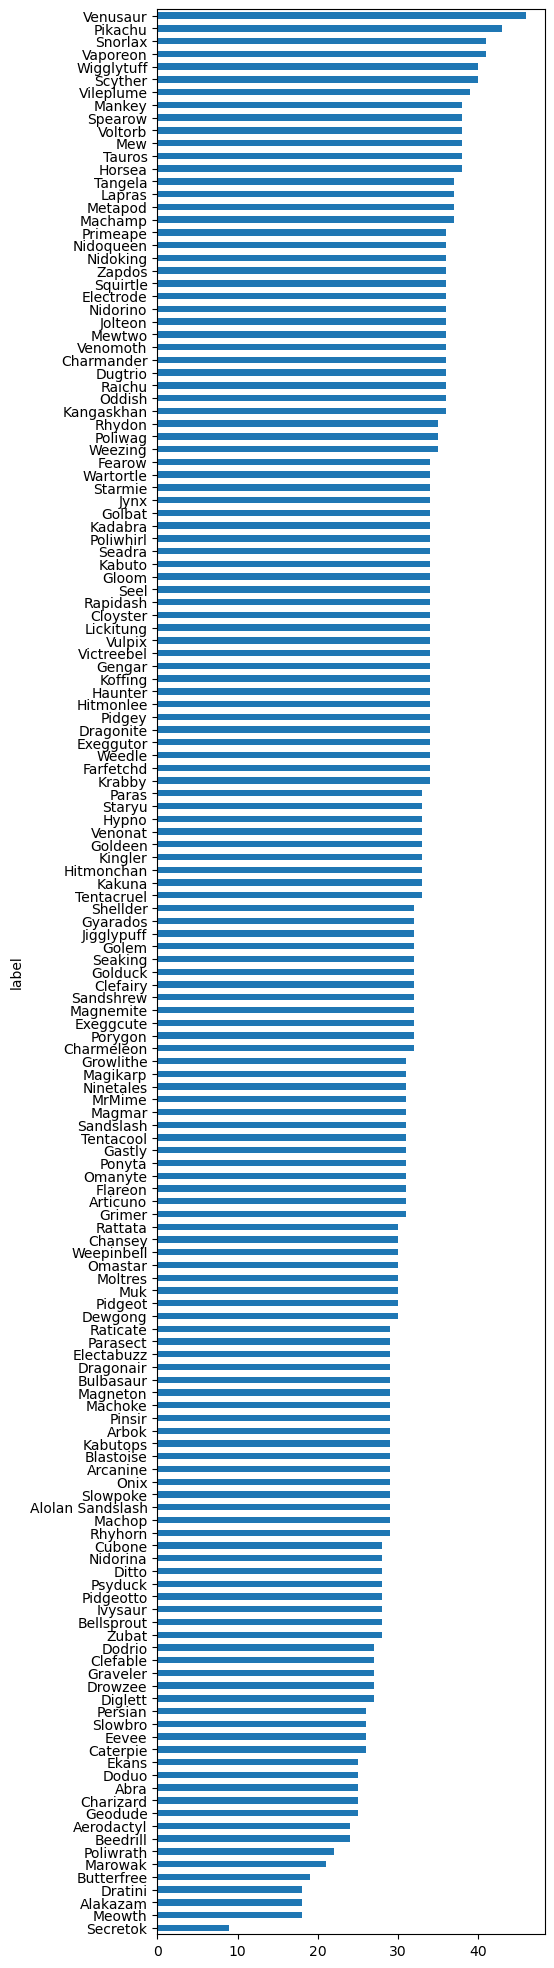

In [ ]:
train_labels.label.value_counts(ascending=True).plot.barh(figsize=(5,25))

In [ ]:
train_labels["label_id"] = train_labels["label"].map(label_map)

In [ ]:
train, val = train_test_split(train_labels[["filename", "label_id"]], test_size=0.2, stratify=train_labels["label_id"], random_state=42)
len(train), len(val)

(3818, 955)

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, label_df=None, transform=None):
        self.image_dir = image_dir
        self.image_labels = label_df
        self.transform = transform
        # self.label_map = label_map

        if label_df is None:
            image_filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
            self.image_labels = pd.DataFrame(image_filenames, columns=['filename'])
            self.image_labels['label'] = image_filenames

        # if self.label_map:
        #     self.image_labels['label'] = self.image_labels['label'].apply(
        #         lambda x: self.label_map[x] if x in self.label_map else x
        #     )

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        filename, label = self.image_labels.iloc[idx]

        im_path = os.path.join(self.image_dir, filename)
        # image = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)
        image = Image.open(im_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            # image = self.transform(image=image)['image']

        return image, label


class MergedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.ds1len = len(self.dataset1)
        self.ds2len = len(self.dataset2)

    def __len__(self):
        return self.ds1len + self.ds2len

    def __getitem__(self, idx):
        if idx < self.ds1len:
            return self.dataset1[idx]
        else:
            return self.dataset2[idx-self.ds1len]

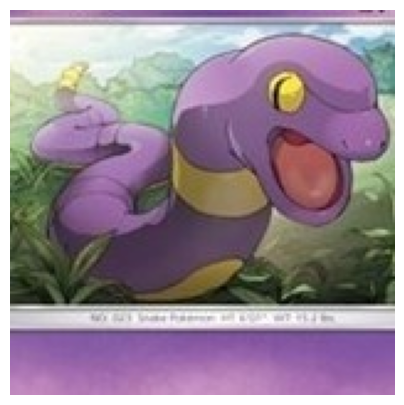

In [ ]:
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

im_path = './train_test_data/train/0a00fe3cd103394e092e4190d2e9d010cbbe649de55939e8f5c5f053b86d52f2.jpg'
# image = cv2.imread(im_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.open(im_path).convert('RGB')
visualize(image)

### Augmentations

Используем TrivialAugment [arXiv:2103.10158](https://arxiv.org/abs/2103.10158)

In [ ]:
transform = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # ...
    v2.TrivialAugmentWide(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),  # Or Resize(antialias=True)
    # ...
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Typical Imagenet norm
    # v2.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
])

transform_val = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # v2.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),
])


Image([[[ 0.4851,  0.4851,  0.4851,  ..., -0.5253, -0.5253, -0.5253],
        [ 0.4508,  0.4508,  0.4508,  ..., -0.3027, -0.3027, -0.3027],
        [ 0.3823,  0.3823,  0.3823,  ...,  0.2111,  0.2111,  0.2111],
        ...,
        [-0.1657, -0.1657, -0.1657,  ..., -0.0801, -0.0801, -0.0801],
        [-0.1486, -0.1486, -0.1486,  ..., -0.7137, -0.7137, -0.7137],
        [-0.1486, -0.1486, -0.1486,  ..., -0.9877, -0.9877, -0.9877]],

       [[ 1.0630,  1.0630,  1.0630,  ..., -0.0574, -0.0574, -0.0574],
        [ 1.0280,  1.0280,  1.0280,  ...,  0.1702,  0.1702,  0.1702],
        [ 0.9230,  0.9230,  0.9230,  ...,  0.6954,  0.6954,  0.6954],
        ...,
        [ 0.4153,  0.4153,  0.4153,  ...,  0.4503,  0.4503,  0.4503],
        [ 0.3978,  0.3978,  0.3978,  ..., -0.2500, -0.2500, -0.2500],
        [ 0.3803,  0.3803,  0.3803,  ..., -0.5301, -0.5301, -0.5301]],

       [[ 1.2282,  1.2282,  1.2282,  ...,  0.3219,  0.3219,  0.3219],
        [ 1.1934,  1.1934,  1.1934,  ...,  0.5485,  0.5485, 

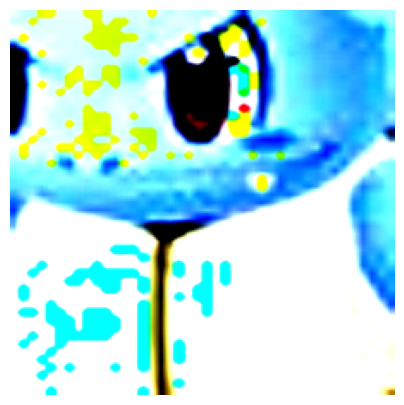

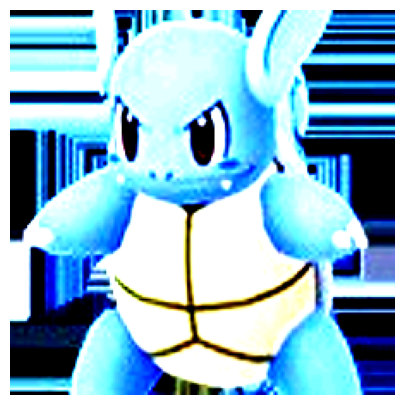

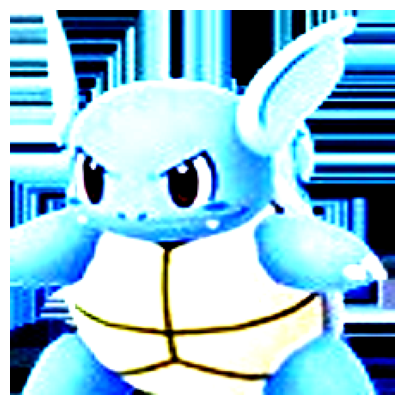

In [ ]:
train_ds = ImageDataset("./train_test_data/train", train, transform=transform)
for i in range(3):
    visualize(train_ds[0][0].movedim(0,-1))
train_ds[0][0]

## Model

In [ ]:
BATCH_SIZE = 32

train_ds = ImageDataset("./train_test_data/train", train, transform=transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

val_ds = ImageDataset("./train_test_data/train", val, transform=transform_val)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

full_train_ds = ImageDataset("./train_test_data/train", train_labels[["filename", "label_id"]], transform=transform)
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = ImageDataset("./train_test_data/test", transform=transform_val)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

def val_model(model):
    val_samples = []
    # model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            preds = model(inputs.to(device).float()).cpu().detach().numpy().argmax(axis=1)
            val_samples.append((preds, labels.numpy()))

    preds, labels = zip(*val_samples)
    return (np.hstack(preds) == np.hstack(labels)).mean()

Модель — ConvNeXt v2 [arXiv:2301.00808](https://arxiv.org/abs/2301.00808) [Github](https://github.com/facebookresearch/ConvNeXt-V2)

Оптимизатор — Schedule-Free Adam [arXiv:2405.15682](https://arxiv.org/abs/2405.15682) [Github](https://github.com/facebookresearch/schedule_free)

In [ ]:
torch.xpu.empty_cache()

# model = timm.create_model('convnextv2_tiny.fcmae', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
model = timm.create_model('convnextv2_base', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
# model = timm.create_model('convnextv2_tiny', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
# model = timm.create_model('convnextv2_nano', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
# model = timm.create_model('convnextv2_atto', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
# model = MyCNN().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=2e-5)
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/convnextv2_base.fcmae_ft_in22k_in1k)
INFO:timm.models._hub:[timm/convnextv2_base.fcmae_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [ ]:
grad_acc_n = 4
grad_acc_counter = itertools.cycle(range(grad_acc_n))

optimizer.zero_grad()

for param in model.parameters():
    param.requires_grad = False

# for param in model.head.parameters():
#     param.requires_grad = True

losses = []
vals = []

num_epochs = 10
num_frozen = 0
last_epoch = 0


for epoch in range(last_epoch, last_epoch+num_epochs):
    if epoch == num_frozen:
        print("Unfreezing model body")
        for param in model.parameters():
            param.requires_grad = True
        # reset optim
        # optimizer = optim.Adam(model.parameters(), lr=1e-4)
        optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4, warmup_steps=20)
        optimizer.zero_grad()

    model.train()
    optimizer.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()

        # optimizer.step()

        if next(grad_acc_counter) == (grad_acc_n - 1):
            optimizer.step()
            optimizer.zero_grad()

        loss = float(loss.item())
        losses.append(loss)
        running_loss += loss * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    optimizer.eval()
    val_acc = val_model(model)
    vals.append(val_acc)
    print(f"Epoch {epoch+1}/{last_epoch+num_epochs}, Loss: {epoch_loss:.4f}, Val acc: {val_acc:.4f}")

print("Training completed")


Unfreezing model body


100%|██████████| 120/120 [02:09<00:00,  1.08s/it]


Epoch 1/10, Loss: 4.8883, Val acc: 0.2660


100%|██████████| 120/120 [01:59<00:00,  1.00it/s]


Epoch 2/10, Loss: 3.3064, Val acc: 0.8010


100%|██████████| 120/120 [02:01<00:00,  1.01s/it]


Epoch 3/10, Loss: 1.6309, Val acc: 0.9277


100%|██████████| 120/120 [02:01<00:00,  1.01s/it]


Epoch 4/10, Loss: 0.8139, Val acc: 0.9455


100%|██████████| 120/120 [02:01<00:00,  1.02s/it]


Epoch 5/10, Loss: 0.5783, Val acc: 0.9508


100%|██████████| 120/120 [01:58<00:00,  1.01it/s]


Epoch 6/10, Loss: 0.4183, Val acc: 0.9602


100%|██████████| 120/120 [02:02<00:00,  1.02s/it]


Epoch 7/10, Loss: 0.3216, Val acc: 0.9644


100%|██████████| 120/120 [02:01<00:00,  1.01s/it]


Epoch 8/10, Loss: 0.3189, Val acc: 0.9675


100%|██████████| 120/120 [02:03<00:00,  1.03s/it]


Epoch 9/10, Loss: 0.2652, Val acc: 0.9675


100%|██████████| 120/120 [02:03<00:00,  1.03s/it]


Epoch 10/10, Loss: 0.2096, Val acc: 0.9686
Training completed


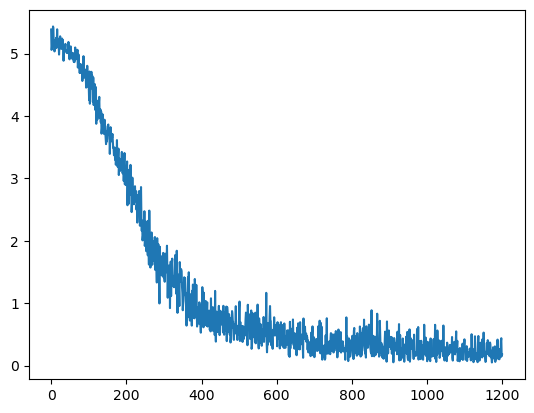

In [ ]:
plt.plot(losses)

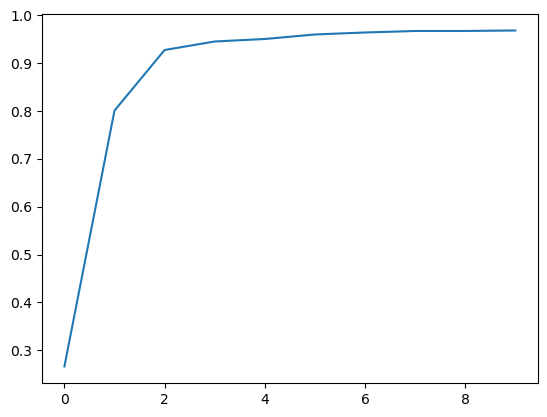

In [ ]:
plt.plot(vals)

In [ ]:
torch.xpu.empty_cache()
model = timm.create_model('convnextv2_base', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/convnextv2_base.fcmae_ft_in22k_in1k)
INFO:timm.models._hub:[timm/convnextv2_base.fcmae_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [ ]:
grad_acc_n = 4
grad_acc_counter = itertools.cycle(range(grad_acc_n))

optimizer.zero_grad()

for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

losses = []
vals = []

num_epochs = 12
num_frozen = 2
last_epoch = 0


for epoch in range(last_epoch, last_epoch+num_epochs):
    if epoch == num_frozen:
        print("Unfreezing model body")
        for param in model.parameters():
            param.requires_grad = True
        # reset optim
        optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4, warmup_steps=20)
        optimizer.zero_grad()

    model.train()
    optimizer.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()

        if next(grad_acc_counter) == (grad_acc_n - 1):
            optimizer.step()
            optimizer.zero_grad()

        loss = float(loss.item())
        losses.append(loss)
        running_loss += loss * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    model.eval()
    optimizer.eval()
    val_acc = val_model(model)
    vals.append(val_acc)
    print(f"Epoch {epoch+1}/{last_epoch+num_epochs}, Loss: {epoch_loss:.4f}, Val acc: {val_acc:.4f}")

print("Training completed")


100%|██████████| 120/120 [01:15<00:00,  1.59it/s]


Epoch 1/12, Loss: 5.0360, Val acc: 0.0283


100%|██████████| 120/120 [01:12<00:00,  1.65it/s]


Epoch 2/12, Loss: 5.0670, Val acc: 0.0440
Unfreezing model body


100%|██████████| 120/120 [01:59<00:00,  1.01it/s]


Epoch 3/12, Loss: 4.9714, Val acc: 0.0660


100%|██████████| 120/120 [02:00<00:00,  1.00s/it]


Epoch 4/12, Loss: 3.9955, Val acc: 0.6963


100%|██████████| 120/120 [01:57<00:00,  1.02it/s]


Epoch 5/12, Loss: 2.0618, Val acc: 0.8942


100%|██████████| 120/120 [01:59<00:00,  1.01it/s]


Epoch 6/12, Loss: 0.9794, Val acc: 0.9319


100%|██████████| 120/120 [02:03<00:00,  1.03s/it]


Epoch 7/12, Loss: 0.5787, Val acc: 0.9508


100%|██████████| 120/120 [02:00<00:00,  1.01s/it]


Epoch 8/12, Loss: 0.4147, Val acc: 0.9518


100%|██████████| 120/120 [02:03<00:00,  1.03s/it]


Epoch 9/12, Loss: 0.3478, Val acc: 0.9592


100%|██████████| 120/120 [02:00<00:00,  1.01s/it]


Epoch 10/12, Loss: 0.2826, Val acc: 0.9665


100%|██████████| 120/120 [02:01<00:00,  1.01s/it]


Epoch 11/12, Loss: 0.2588, Val acc: 0.9675


100%|██████████| 120/120 [02:03<00:00,  1.03s/it]


Epoch 12/12, Loss: 0.2177, Val acc: 0.9654
Training completed


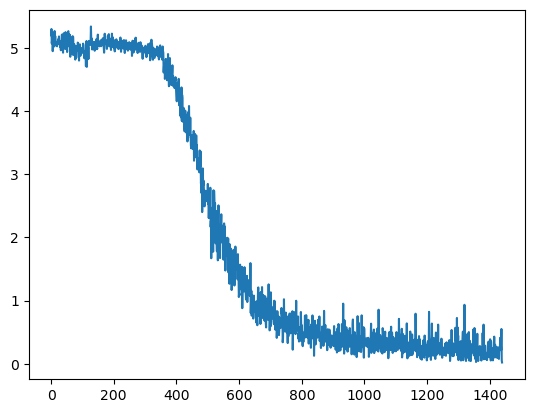

In [ ]:
plt.plot(losses)

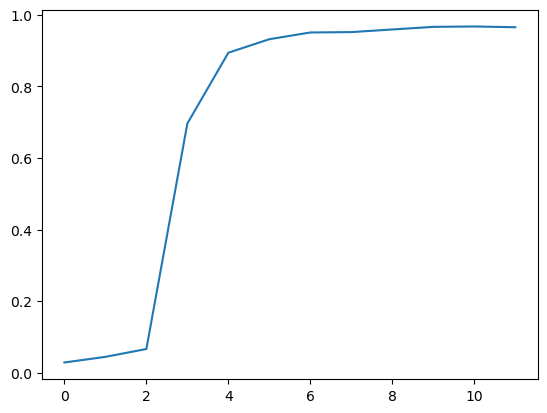

In [ ]:
plt.plot(vals)

### Full train run

In [ ]:
torch.xpu.empty_cache()
model = timm.create_model('convnextv2_base', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/convnextv2_base.fcmae_ft_in22k_in1k)
INFO:timm.models._hub:[timm/convnextv2_base.fcmae_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [ ]:
grad_acc_n = 4
grad_acc_counter = itertools.cycle(range(grad_acc_n))

optimizer.zero_grad()

for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

losses = []

num_epochs = 10
num_frozen = 1
last_epoch = 0

for epoch in range(last_epoch, last_epoch+num_epochs):
    if epoch == num_frozen:
        print("Unfreezing model body")
        for param in model.parameters():
            param.requires_grad = True
        # reset optim
        optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4, warmup_steps=20)
        optimizer.zero_grad()

    model.train()
    optimizer.train()
    running_loss = 0.0
    for inputs, labels in tqdm(full_train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()

        if next(grad_acc_counter) == (grad_acc_n - 1):
            optimizer.step()
            optimizer.zero_grad()

        loss = float(loss.item())
        losses.append(loss)
        running_loss += loss * inputs.size(0)

    epoch_loss = running_loss / len(full_train_loader.dataset)

    print(f"Epoch {epoch+1}/{last_epoch+num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
optimizer.eval()

print("Training completed")


100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


Epoch 1/10, Loss: 5.0344
Unfreezing model body


100%|██████████| 150/150 [02:38<00:00,  1.05s/it]


Epoch 2/10, Loss: 4.3015


100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


Epoch 3/10, Loss: 2.1331


100%|██████████| 150/150 [02:32<00:00,  1.02s/it]


Epoch 4/10, Loss: 0.8969


100%|██████████| 150/150 [02:30<00:00,  1.01s/it]


Epoch 5/10, Loss: 0.5295


100%|██████████| 150/150 [02:31<00:00,  1.01s/it]


Epoch 6/10, Loss: 0.3838


100%|██████████| 150/150 [02:30<00:00,  1.01s/it]


Epoch 7/10, Loss: 0.3094


100%|██████████| 150/150 [02:32<00:00,  1.02s/it]


Epoch 8/10, Loss: 0.2574


100%|██████████| 150/150 [02:30<00:00,  1.00s/it]


Epoch 9/10, Loss: 0.2520


100%|██████████| 150/150 [02:33<00:00,  1.02s/it]

Epoch 10/10, Loss: 0.2147
Training completed


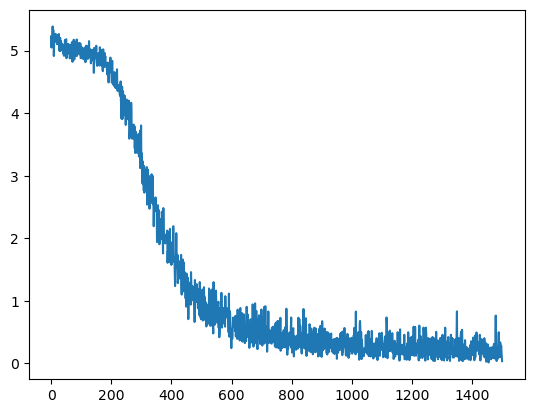

In [ ]:
plt.plot(losses)

In [ ]:
preds_list = []
labels_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        preds = model(inputs.to(device).float()).cpu().detach().numpy().argmax(axis=1)
        preds_list.append(preds)
        labels_list.append(labels)

100%|██████████| 64/64 [00:21<00:00,  2.94it/s]


In [ ]:
res_df = pd.DataFrame({"filename":list(itertools.chain(*labels_list)), "label":np.hstack(preds_list)})
res_df.label = res_df.label.map(pd.Series(cls_labels))
res_df

,filename,label
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,Cloyster
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,Omanyte
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,Squirtle
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,Clefable
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,Staryu
...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,Vulpix
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,Alolan Sandslash
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,Machop
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,Drowzee


In [ ]:
# res_df.to_csv("07_convnextv2_base_ft.csv", index=False)
# # save_model(model, "07_convnextv2_base_ft.st")
# torch.save(model.state_dict(), "07_convnextv2_base_ft.pt")

### Pseudo labeling

In [ ]:
model = timm.create_model('convnextv2_base', checkpoint_path="./07_convnextv2_base_ft.pt", num_classes=NUM_FINETUNE_CLASSES).to(device)

In [ ]:
probs_list = []
preds_list = []
labels_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        probs, preds = model(inputs.to(device).float()).cpu().detach().softmax(0).max(1)#.numpy().argmax(axis=1)
        probs_list.append(probs.numpy())
        preds_list.append(preds.numpy())
        labels_list.append(labels)

100%|██████████| 64/64 [00:21<00:00,  3.02it/s]


In [ ]:
res_df = pd.DataFrame({"filename":list(itertools.chain(*labels_list)), "label":np.hstack(preds_list), "proba":np.hstack(probs_list)})
res_df

,filename,label,proba
0,002562cdd2d17ee1e67fb26a309ed1edef4b8219eb2233...,19,0.998973
1,002b01cfd29fd12cbd48b042cca54b7b031b3a3d0adeb9...,93,0.992919
2,002d30ddeff893fdca5e187e4f348f6f537b2f80d8d2a3...,129,0.689821
3,0073c8c962ea13ae6e838a5f2d38f7f12b096abb2f2a90...,128,0.378465
4,00adf017914bb974c2524a3fd2fc049b08f83cb07480a6...,131,0.391032
...,...,...,...
2041,fec6f8f6ea7955eea8ca1b53204ebc0e62de29d93bce05...,143,0.999445
2042,fef4c94968e13ad30e081e94a3b24fa815a22fb79a43c3...,3,0.996920
2043,ff1830fd4fbb147d9b385e9be0a5eeb2745478cf8d2338...,73,0.999564
2044,ff516479938d0fc78b67e2c90a70703b0239e40a81b959...,29,0.992190


In [ ]:
res_df.proba.quantile(np.arange(0.0, 1.0, 0.1))

0.0    0.187981
0.1    0.570013
0.2    0.917263
0.3    0.990326
0.4    0.995817
0.5    0.997572
0.6    0.998385
0.7    0.998838
0.8    0.999156
0.9    0.999405
Name: proba, dtype: float64

In [ ]:
pseudo_label_ds = ImageDataset("./train_test_data/test", res_df[res_df.proba > 0.995][["filename", "label"]], transform=transform)
combined_ds = MergedDataset(full_train_ds, pseudo_label_ds)

combined_loader = DataLoader(combined_ds, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
del model
torch.xpu.empty_cache()
model = timm.create_model('convnextv2_base', pretrained=True, num_classes=NUM_FINETUNE_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/convnextv2_base.fcmae_ft_in22k_in1k)
INFO:timm.models._hub:[timm/convnextv2_base.fcmae_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


100%|██████████| 190/190 [02:23<00:00,  1.33it/s]


Epoch 1/10, Loss: 5.0341
Unfreezing model body


100%|██████████| 190/190 [03:17<00:00,  1.04s/it]


Epoch 2/10, Loss: 3.9576


100%|██████████| 190/190 [03:14<00:00,  1.02s/it]


Epoch 3/10, Loss: 1.5127


100%|██████████| 190/190 [03:14<00:00,  1.02s/it]


Epoch 4/10, Loss: 0.6219


100%|██████████| 190/190 [03:18<00:00,  1.05s/it]


Epoch 5/10, Loss: 0.4207


100%|██████████| 190/190 [03:18<00:00,  1.04s/it]


Epoch 6/10, Loss: 0.3388


100%|██████████| 190/190 [03:23<00:00,  1.07s/it]


Epoch 7/10, Loss: 0.3027


100%|██████████| 190/190 [03:16<00:00,  1.04s/it]


Epoch 8/10, Loss: 0.2534


100%|██████████| 190/190 [03:21<00:00,  1.06s/it]


Epoch 9/10, Loss: 0.2148


100%|██████████| 190/190 [03:22<00:00,  1.07s/it]


Epoch 10/10, Loss: 0.1922
Training completed


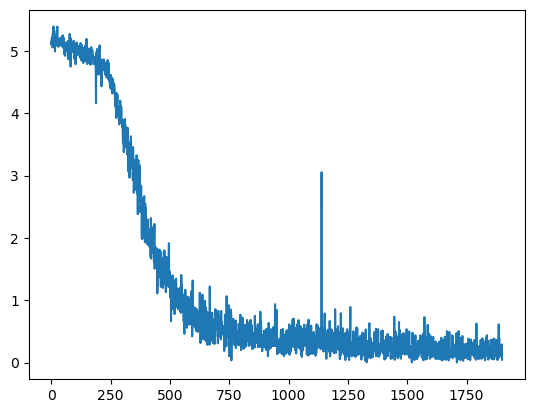

In [ ]:
grad_acc_n = 4
grad_acc_counter = itertools.cycle(range(grad_acc_n))

optimizer.zero_grad()

for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

losses = []

num_epochs = 10
num_frozen = 1
last_epoch = 0

for epoch in range(last_epoch, last_epoch+num_epochs):
    if epoch == num_frozen:
        print("Unfreezing model body")
        for param in model.parameters():
            param.requires_grad = True
        # reset optim
        optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr=1e-4, warmup_steps=20)
        optimizer.zero_grad()

    model.train()
    optimizer.train()
    running_loss = 0.0
    for inputs, labels in tqdm(combined_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()

        if next(grad_acc_counter) == (grad_acc_n - 1):
            optimizer.step()
            optimizer.zero_grad()

        loss = float(loss.item())
        losses.append(loss)
        running_loss += loss * inputs.size(0)

    epoch_loss = running_loss / len(combined_loader.dataset)

    print(f"Epoch {epoch+1}/{last_epoch+num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
optimizer.eval()

plt.plot(losses)
print("Training completed")

In [ ]:
preds_list = []
labels_list = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        preds = model(inputs.to(device).float()).cpu().detach().numpy().argmax(axis=1)
        preds_list.append(preds)
        labels_list.append(labels)

100%|██████████| 64/64 [00:20<00:00,  3.06it/s]


In [ ]:
res_df = pd.DataFrame({"filename":list(itertools.chain(*labels_list)), "label":np.hstack(preds_list)})
res_df.label = res_df.label.map(pd.Series(cls_labels))


In [ ]:
res_df.to_csv("09_convnextv2_base_pseudolabeling.csv", index=False)
torch.save(model.state_dict(), "09_convnextv2_base_pseudolabeling.pt")

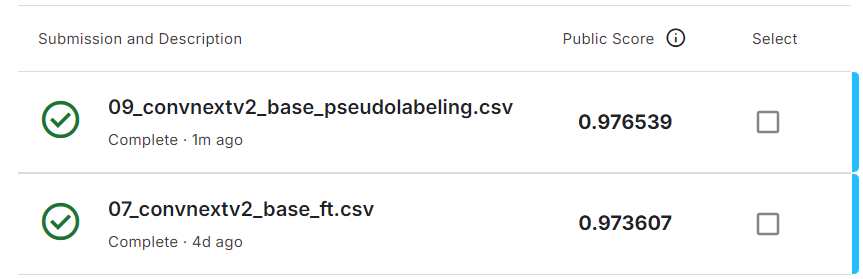